# Probabilistic Time Series Analysis

## Week 5: Recurrent Neural Networks

Places where you are supposed to fill in code are marked

    #
    # TODO: some instructions
    # 
    
The rest of the code we will run and discuss if time permits, otherwise try it out at home and try to answer the questions mentioned in the text boxes for yourself.

---

In [1]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

## Step 1: Data Preprocessing

In [2]:
# NOTE: When you try different datasets, change the filename in this line:
#
# I've gathered some text files for you to try, but feel free to use the code on your own that you find online.
# The prepared examples are (all in the data directory on Github):
# - catcher.txt
# - boh.txt
# - holmes.txt
# - war.txt
# - quotes.txt
data = open('../../data/catcher.txt', 'r').read()
data_size = len(data)
data = data + ' '

In [3]:
#
# TODO: Create a one-hot encoding for characters that occur in your text file by following the instructions below.
# 

# This should contain a list of unique characters:
chars = list(set(data))

vocab_size = len(chars)

print('Input data has %d characters, %d unique.' % (data_size, vocab_size))

# These should be dictionaries of character-to-index in `chars` and index-to-character:
char_to_ix = {char_i: i for i, char_i in enumerate(chars)}    
ix_to_char = {i:char_i for i, char_i in enumerate(chars)} 

# Some error checking for you
assert(set(char_to_ix.keys()) == set(ix_to_char.values()))
assert(set(ix_to_char.keys()) == set(char_to_ix.values()))

Input data has 377160 characters, 85 unique.


## Step 2: Training

In [61]:
def lossFun(inputs, targets, hprev):
    """
    inputs,targets are both list of integers.
    hprev is Hx1 array of initial hidden state
    returns the loss, gradients on model parameters, and last hidden state
    """
    xs, hs, ys, ps = {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    loss = 0
    # forward pass
    for t in range(len(inputs)):
        xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
        ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
    # backward pass: compute gradients going backwards
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext # backprop into h
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(Whh.T, dhraw)
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

def sample(h, seed_ix, n, temp=1.0):
    """ 
    sample a sequence of integers from the model 
    h is memory state, seed_ix is seed letter for first time step
    """
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        y = np.dot(Why, h) + by
        p = np.exp(y / temp) / np.sum(np.exp(y / temp))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

In [87]:
# Hyperparameters
hidden_size = 100  # size of hidden layer of neurons
seq_length = 50    # number of steps to unroll the RNN for
learning_rate = 1e-1 # old 5e-2
maxiters = 20000
gamma = 0.99995

# Model parameters
Wxh = np.random.randn(hidden_size, vocab_size) * 0.01  # input to hidden
Whh = np.random.randn(hidden_size, hidden_size) * 0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size) * 0.01  # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias


n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

unsmoothed_losses = []
smoothed_losses = []
gradients = []
lrates = []

while n < maxiters:
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # sample from the model now and then
    if n % 1000 == 0:
        sample_ix = sample(hprev, inputs[0], 200)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print('----\n %s \n----' % (txt, ))

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    
    if n % 200 == 0:
        unsmoothed_losses.append(loss)
        smoothed_losses.append(smooth_loss)
        gradients.append((dWxh, dWhh, dWhy, dbh, dby))
        lrates.append(learning_rate)
    
    if n % 500 == 0: 
        print('iter %d, loss: %f' % (n, smooth_loss)) # print progress
  
    # perform parameter update with Adagrad
    learning_rate *= gamma
    for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                  [dWxh, dWhh, dWhy, dbh, dby], 
                                  [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter 

----
 )!_YWNY-e oI H4d6“—xIDiJryP8bd:.ADb(DS“DA93dWb“0QL56lTE6k:7‘ -O;âTjYwACyLégcjh8F_iCpuO8C?A[C ’K-E[7—yMI]ZF7Zs!gnGykJB#bc9_”-w9WC4auU“QzW#tL-_l8[]FEi
hG1vvt0”s9DT#OV?h-IQr,)YOf…_…68jq0r?Ab86RyLicAo, —f 
----
iter 0, loss: 222.132559
iter 500, loss: 194.850350
----
 d is At pa ciyed axddrey aihe ca d ishe wet the wed ant. “ken thinw “k?an rourhe of’ yat. Bam?gyong, is Yeal Yorw.iln”
“Is ham tiingent At hes mea,t. Theng. whe ir at rasl Thim inlt. “Hh yan. yieo wou 
----
iter 1000, loss: 167.688167
iter 1500, loss: 148.413707
----
  kfe n doy. Svelefe thoyyy’t m as hy frssillingt wt uid kalwr mut twtas. The. BuPatinct and tid I saf juy, ifc tht mowibisry I lulr oncelte.yy th thar at asr os o meds forsty meseyroun xy badn Bupve T 
----
iter 2000, loss: 135.823248
iter 2500, loss: 127.189395
----
 tony ore “Woby hist wus daf sing an tidyit, so bong yome fhime anm winmcte. Azy ofr andy sar, Eis, thools. Is therttonh ekez, a antasl rathin’t abountre the.” The jome bo wann sar ulny ind ph

## Step 3: Evaluation

In [81]:
def PlotLoss(title):
    global smoothed_losses, unsmoothed_losses, lrates
    smoothed_losses = np.array(smoothed_losses)
    unsmoothed_losses = np.array(unsmoothed_losses)
    lrates = np.array(lrates)
    x = np.arange(0, smoothed_losses.shape[0])

    plt.figure(figsize=(10,6))
    plt.plot(x, smoothed_losses, 'g', label='smoothed losses')
    plt.plot(x, unsmoothed_losses, 'b', label='unsmoothed losses')
    plt.plot(x, lrates * 1000, 'r', label='learning rate * 1000')
    plt.xlabel('period')
    plt.ylabel('loss')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

### Exponentially Decreasing learning rate

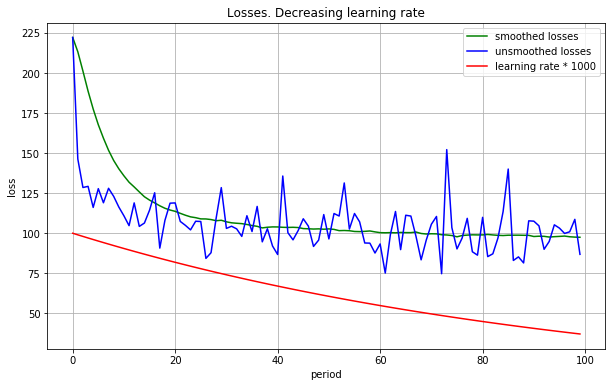

In [89]:
# params
# 
# hidden_size = 100  # size of hidden layer of neurons
# seq_length = 50    # number of steps to unroll the RNN for
# learning_rate = 1e-1 # old 5e-2
# maxiters = 20000
# gamma = 0.99995
PlotLoss('Losses. Decreasing learning rate')

### Gradually decreasing learning rate

In [117]:
# Hyperparameters
hidden_size = 100  # size of hidden layer of neurons
seq_length = 50    # number of steps to unroll the RNN for
learning_rate = 1e-1 # old 5e-2
maxiters = 40000
gamma = 0.7

# Model parameters
Wxh = np.random.randn(hidden_size, vocab_size) * 0.01  # input to hidden
Whh = np.random.randn(hidden_size, hidden_size) * 0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size) * 0.01  # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias


n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

unsmoothed_losses = []
smoothed_losses = []
gradients = []
lrates = []

while n < maxiters:
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # sample from the model now and then
    if n % 1000 == 0:
        sample_ix = sample(hprev, inputs[0], 200)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print('----\n %s \n----' % (txt, ))

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    
    if n % 200 == 0:
        unsmoothed_losses.append(loss)
        smoothed_losses.append(smooth_loss)
        gradients.append((dWxh, dWhh, dWhy, dbh, dby))
        lrates.append(learning_rate)
    
    if n % 500 == 0: 
        print('iter %d, loss: %f' % (n, smooth_loss)) # print progress
          
    # update learning rate
    if n > 0 and n % 3500 == 0 and smoothed_losses[-1] / smoothed_losses[-15] > 0.97: 
        learning_rate *= gamma
        print(learning_rate)
    
    # early stop 
    if n > 0 and n % 5000 == 0 and smoothed_losses[-1] / smoothed_losses[-25] > 0.99:
        print(n, "early stop")
        break
    
    for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                  [dWxh, dWhh, dWhy, dbh, dby], 
                                  [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter 

----
 0…)D)9-(zZz ’J,Pb?b…I”xâB_q—KLjCu“ZqLaSMLnTq_KMu5YPs”I“hlVZaF-5P# 9NEWs‘PbUtz—‘U?Y9xqI‘M2jlF5WhLHh5zcJ 5B5oP:7o4n8R7-:uf’gN UFeOr3?.qx-irK,j:;][ZWoMa—âr—r2Q!;
!ihPd”u)fmZWgozav…f(‘“EWH_3G1
LdkFéS9d;,a 
----
iter 0, loss: 222.132548
iter 500, loss: 196.932565
----
 dopssave yethan’w ak thing anchees.”
Taln thonp parknook dhiada ut m,.””
“Nye re wfice thileis ar, he haslin lhor th tey bid bous poso thise Whesthea thisgitinb mer, wove yout ar ges in sladd —asp sal 
----
iter 1000, loss: 169.169074
iter 1500, loss: 147.971116
----
  holy it. The do’t the daghines nowdrirling ooln whel wat athott iip eret thil wad rougrtn’t lout cony, he we’d lef andrenst us alll hea mexnet an’t that inlet ttat ory bNoyt acl af ir. “But torr ans. 
----
iter 2000, loss: 133.659113
iter 2500, loss: 123.720197
----
 al a gun puzme ff and the polla kid tigein tore acase aid a calr wa, do igh thek lom to thut ha hed at Po mma hing ove coulr, nec. And tasdess neE came thin solle fa wcpst wist this you than 

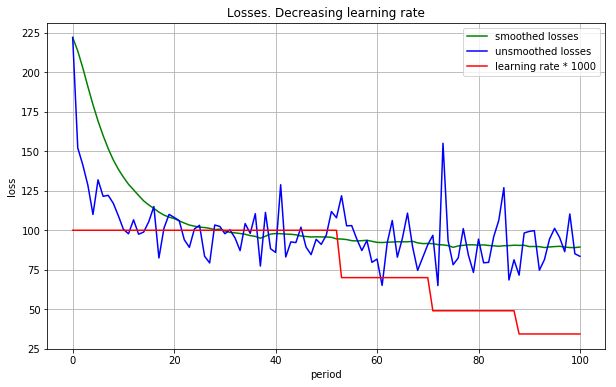

In [118]:
PlotLoss('Losses. Decreasing learning rate')

### learning rate = 5e-2

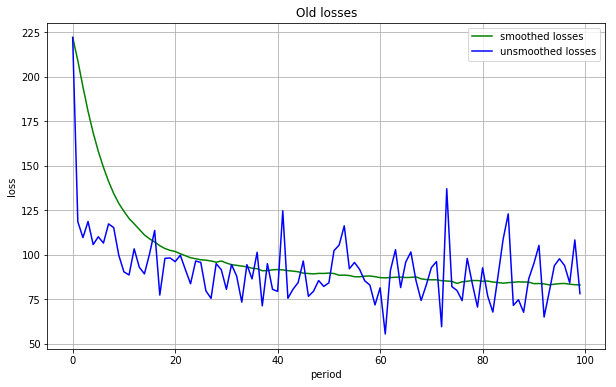

In [43]:
# 
# TODO: The variables `unsmoothed_losses` and `smoothed_losses` contain periodically 
# sampled training losses, and in the latter we take a moving average. Plot these two
# in this cell. What do you notice?
#

old_smoothed_losses = np.array(smoothed_losses)
old_unsmoothed_losses = np.array(unsmoothed_losses)

# Plot using the `old_` variables, since you're going to re-run the code below with
# different parameters.
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, old_smoothed_losses.shape[0]), old_smoothed_losses, 'g', label='smoothed losses')
plt.plot(np.arange(0, old_smoothed_losses.shape[0]), old_unsmoothed_losses, 'b', label='unsmoothed losses')
plt.xlabel('period')
plt.ylabel('loss')
plt.title(title)
plt.legend()
plt.grid()
plt.show()

# old learning rate = 5e-2

We have plateau in the end. It means the algorithm doesn't learn anymore.

### learning rate = 2e-1

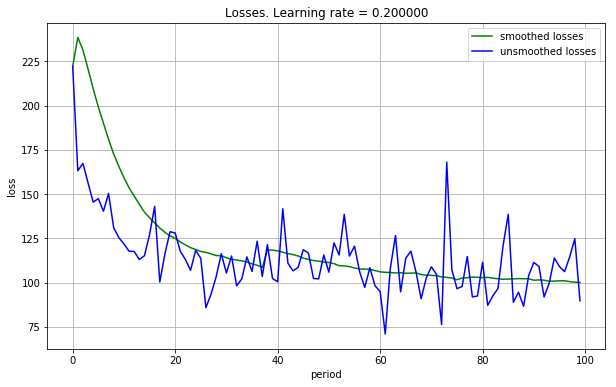

In [48]:
# 
# TODO: Change the learning rate, run the training code again, and plot the new results
# (leave the old results in the cell above). What do you notice? How could we tune this
# hyperparameter? If you have time, try modifying the code to vary the learning rate
# over time. See what happens.
# 

# Now plot using the variables without `old_`, after re-running.
smoothed_losses = np.array(smoothed_losses)
unsmoothed_losses = np.array(unsmoothed_losses)

plt.figure(figsize=(10,6))
plt.plot(np.arange(0, smoothed_losses.shape[0]), smoothed_losses, 'g', label='smoothed losses')
plt.plot(np.arange(0, smoothed_losses.shape[0]), unsmoothed_losses, 'b', label='unsmoothed losses')
plt.xlabel('period')
plt.ylabel('loss')
plt.title('Losses. Learning rate = %f' %learning_rate)
plt.legend()
plt.grid()
plt.show()

### learning rate = 1e-2

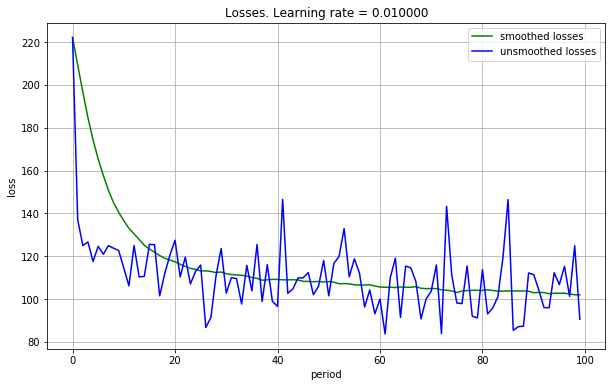

In [50]:
smoothed_losses = np.array(smoothed_losses)
unsmoothed_losses = np.array(unsmoothed_losses)

plt.figure(figsize=(10,6))
plt.plot(np.arange(0, smoothed_losses.shape[0]), smoothed_losses, 'g', label='smoothed losses')
plt.plot(np.arange(0, smoothed_losses.shape[0]), unsmoothed_losses, 'b', label='unsmoothed losses')
plt.xlabel('period')
plt.ylabel('loss')
plt.title('Losses. Learning rate = %f' %learning_rate)
plt.legend()
plt.grid()
plt.show()

### Gradients

In [12]:
#
# TODO: The variable `gradients` is a list of tuples of gradients for each of the variables
# in the network (some are matrices). Compute the norms of the gradients of the variables
# at each time step and make plots (use np.linalg.norm(X, ord='fro') for matrices). What
# do you notice? Do you observe convergence? You might want to try smoothing the gradient norms.
#

# Example of contents of gradients:
for value, name in zip(gradients[0], ['dWxh', 'dWhh', 'dWhy', 'dbh', 'dby']):
    print(name, ':')
    print(np.linalg.norm(, ord='fro'))
    print('')

dWxh :
0.7106731709937094

dWhh :
0.07311871223648107

dWhy :
0.7373783352959948

dbh :
1.0428597465197749

dby :
10.704580172154678



In [18]:
cols = ['dWxh', 'dWhh', 'dWhy', 'dbh', 'dby']
df = np.zeros((len(gradients), 5))
for i in range(len(gradients)):
    for value, j in zip(gradients[i], range(len(cols))):
        df[i, j] = np.linalg.norm(value, ord='fro')

In [39]:
# I took function for EWMA (exponential-weighted-moving-average) from here:
# https://stackoverflow.com/questions/42869495/numpy-version-of-exponential-weighted-moving-average-equivalent-to-pandas-ewm
def ewma(x, alpha):
    '''
    Returns the exponentially weighted moving average of x.

    Parameters:
    -----------
    x : array-like
    alpha : float {0 <= alpha <= 1}

    Returns:
    --------
    ewma : numpy array
        the exponentially weighted moving average
    '''
    # coerce x to an array
    x = np.array(x)
    n = x.size
    # create an initial weight matrix of (1-alpha), and a matrix of powers
    # to raise the weights by
    w0 = np.ones(shape=(n,n)) * (1-alpha) 
    p = np.vstack([np.arange(i,i-n,-1) for i in range(n)])
    # create the weight matrix
    w = np.tril(w0**p,0)
    # calculate the ewma
    return np.dot(w, x[::np.newaxis]) / w.sum(axis=1)

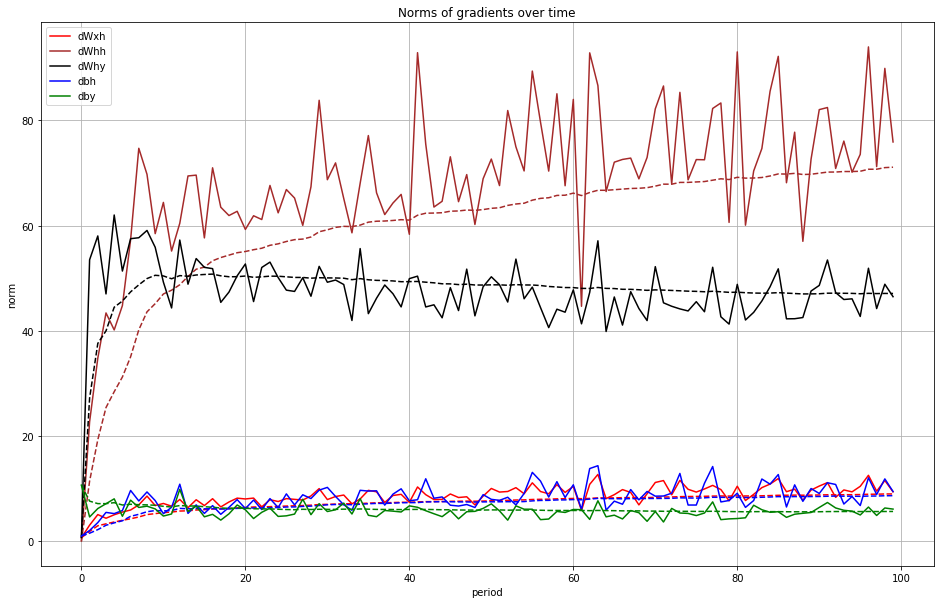

In [57]:
x = np.arange(0, df.shape[0])

plt.figure(figsize=(16,10))
colors = ['red', 'brown', 'black', 'blue', 'green']
for i, col in enumerate(cols):
    plt.plot(x, df[:, i], colors[i], label=col)
    plt.plot(x, ewma(df[:, i], 0.01), colors[i], linestyle='--')
plt.xlabel('period')
plt.ylabel('norm')
plt.title('Norms of gradients over time')
plt.legend()
plt.grid()
plt.show()

In [60]:
#
# TODO: Here is an example of sampling from the trained network. The parameter `temp` can
# be tuned to vary the probability distribution from which we sample. The default is 1.0.
# Pass in different values and print a few samples with each. What's the difference?
#

# Example of sampling:
for temp in [0.005, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0]:
    sample_ix = sample(hprev, inputs[0], 200, temp=temp)
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    print('temp = %.3f\n%s\n' % (temp, txt))

temp = 0.005
âsâââiâââ aââ âââiâââ aââ âââiâââ aââ âââiâââ aââ âââiâââ aââ âââiâââ aââ âââiâââ aââ âââiâââ aââ âââiâââ aââ âââiâââ aââ âââiâââ aââ âââiâââ aââ âââiâââ aââ âââiâââ aââ âââiâââ aââ âââiâââ aââ âââiââ

temp = 0.010
therâ andâe the saiâs and all and all and all and all and all and all and all and all and all and all and all and all and all and all and all and all and all and all and all and all and all and all an

temp = 0.100
ther the said the was and all and all of the was a was and all and all and all and all the had and all and all and all on the was and all and all and all and all and all and all and all and all and al

temp = 0.500
by and the and it her and the was a wast the sover she was all the was ald all the ond he was a loing the was her the to cane all. She said and her she me the all and and when the saddand all and He w

temp = 1.000
my sed all” t“-frithrabod. I houlso hrowe to or but but stomentso An.az keater. You’d ance Lisiing on it to thut fillbe, and wh

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in less


# References

These lab materials are based on Andrej Karpathy's blog post and implementation:

https://karpathy.github.io/2015/05/21/rnn-effectiveness/

https://gist.github.com/karpathy/d4dee566867f8291f086